In [9]:
from google.colab import files

uploaded = files.upload()  # pick your train.csv
train_path = next(iter(uploaded.keys()))
print("Using train file:", train_path)

Saving train.csv to train (1).csv
Using train file: train (1).csv


In [10]:
uploaded = files.upload()  # pick your test.csv
test_path = next(iter(uploaded.keys()))
print("Using test file:", test_path)

Saving test.csv to test (1).csv
Using test file: test (1).csv


First, we load the necessary Python packages.

In [11]:
import re
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt

Second, functions responsible for data loading and preprocessing are written.

In [12]:
# ---------- 1. Data loading & preprocessing ----------

def simple_clean(text: str) -> str:
    """
    Basic text cleaning:
      - Lowercase
      - Remove weird characters
      - Normalize whitespace
    """
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"[^a-z0-9'?!.:, ]+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


def load_data(path="train.csv") -> pd.DataFrame:
    """
    Load train.csv with:
      - Question (input text)
      - category (label)
    """
    df = pd.read_csv(path)
    df = df[["Question", "category"]].dropna()
    df["Question"] = df["Question"].apply(simple_clean)
    return df

We train a simple feedforward neural network. We will search the hyperparameters on the validation set.

In [13]:
# ---------- 2. Build model pipeline (TF-IDF + MLP) ----------
def build_pipeline(hidden_units=128, alpha=1e-4) -> Pipeline:
    """
    Pipeline:
      1) TF-IDF vectorizer
      2) MLPClassifier (simple feedforward neural net)
    """
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.9,
            stop_words="english",
        )),
        ("clf", MLPClassifier(
            hidden_layer_sizes=(hidden_units,),
            activation="relu",
            solver="adam",
            alpha=alpha,
            max_iter=40,       # bump up if you want more training
            early_stopping=True,
            random_state=42,
        )),
    ])
    return pipe

Model is evaluated by publishing a classification report and a confusion matrix>

In [14]:
# ---------- 3. Evaluation helper ----------
def evaluate_model(model, X, y_int, label_encoder: LabelEncoder, split_name=""):
    """
    Evaluate model on a given split (train/val/test).

    y_int: integer labels
    label_encoder: to map back to string labels for printing confusion matrix axes.
    """
    y_pred_int = model.predict(X)

    # Accuracy
    acc = accuracy_score(y_int, y_pred_int)
    print(f"\n=== {split_name} Accuracy ===")
    print(f"{acc:.4f}")

    # Convert ints back to string labels for nice reports
    y_true = label_encoder.inverse_transform(y_int)
    y_pred = label_encoder.inverse_transform(y_pred_int)

    print(f"\n=== {split_name} Classification Report ===")
    print(classification_report(y_true, y_pred))

    # Confusion matrix in terms of string labels
    labels = list(label_encoder.classes_)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    print(f"=== {split_name} Confusion Matrix ===")
    print(cm)

    # Heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        xticklabels=labels,
        yticklabels=labels,
        cmap="Blues",
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix – {split_name}")
    plt.tight_layout()
    plt.show()

In [15]:
# ---------- 4. Main: train/val/test splitting + MLP ----------
def main():
    # ---- Load data ---- #
    print("Loading data...")
    df = load_data("train.csv")
    print(f"Total samples: {len(df)}")
    print("Category distribution:")
    print(df["category"].value_counts(), "\n")

    X_all = df["Question"]
    y_all_str = df["category"]

    # ---- Encode labels as integers (avoids isnan issues) ---- #
    le = LabelEncoder()
    y_all = le.fit_transform(y_all_str)
    print("Label classes (int -> label):")
    for i, c in enumerate(le.classes_):
        print(f"  {i} -> {c}")

    # ---- Split into train / validation / test ---- #
    # 1) train_val (80%) vs test (20%)
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X_all,
        y_all,
        test_size=0.2,
        random_state=42,
        stratify=y_all,
    )

    # 2) train (60% overall) vs val (20% overall)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val,
        y_train_val,
        test_size=0.25,      # 0.25 of 0.8 = 0.2 overall
        random_state=42,
        stratify=y_train_val,
    )

    print(f"\nTrain size: {len(X_train)}")
    print(f"Validation size: {len(X_val)}")
    print(f"Test size: {len(X_test)}")

    # ---- Simple hyperparameter search on train/val ---- #
    hyperparams = [
        {"hidden_units": 64, "alpha": 1e-4},
        {"hidden_units": 128, "alpha": 1e-4},
        {"hidden_units": 128, "alpha": 1e-3},
        {"hidden_units": 256, "alpha": 1e-4},
    ]

    best_f1 = -1.0
    best_params = None
    best_model = None

    print("\nSearching hyperparameters on TRAIN/VALIDATION...")
    for hp in hyperparams:
        print(f"\nTrying config: hidden_units={hp['hidden_units']}, alpha={hp['alpha']}")
        model = build_pipeline(hidden_units=hp["hidden_units"], alpha=hp["alpha"])
        model.fit(X_train, y_train)

        y_val_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_val_pred, average="macro")
        print(f"Validation macro F1: {f1:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            best_params = hp
            best_model = model

    print("\nBest validation macro F1:", best_f1)
    print("Best hyperparameters:", best_params)

    # Show full validation metrics for best model
    evaluate_model(best_model, X_val, y_val, label_encoder=le, split_name="Validation (Best MLP)")

    # ---- Train final model on TRAIN+VAL with best hyperparams ---- #
    print("\nTraining final model on TRAIN+VALIDATION with best hyperparameters...")
    final_model = build_pipeline(
        hidden_units=best_params["hidden_units"],
        alpha=best_params["alpha"],
    )
    X_train_full = pd.concat([X_train, X_val])
    y_train_full = np.concatenate([y_train, y_val])
    final_model.fit(X_train_full, y_train_full)

    # ---- Final evaluation on TEST set ---- #
    print("\nEvaluating final model on TEST set...")
    evaluate_model(final_model, X_test, y_test, label_encoder=le, split_name="Test")

Loading data...
Total samples: 20572
Category distribution:
category
caring          4151
friendly        4147
witty           4107
professional    4107
enthusiastic    4060
Name: count, dtype: int64 

Label classes (int -> label):
  0 -> caring
  1 -> enthusiastic
  2 -> friendly
  3 -> professional
  4 -> witty

Train size: 12342
Validation size: 4115
Test size: 4115

Searching hyperparameters on TRAIN/VALIDATION...

Trying config: hidden_units=64, alpha=0.0001
Validation macro F1: 0.0916

Trying config: hidden_units=128, alpha=0.0001
Validation macro F1: 0.1336

Trying config: hidden_units=128, alpha=0.001
Validation macro F1: 0.1341

Trying config: hidden_units=256, alpha=0.0001
Validation macro F1: 0.1406

Best validation macro F1: 0.1406342377734559
Best hyperparameters: {'hidden_units': 256, 'alpha': 0.0001}

=== Validation (Best MLP) Accuracy ===
0.1541

=== Validation (Best MLP) Classification Report ===
              precision    recall  f1-score   support

      caring      

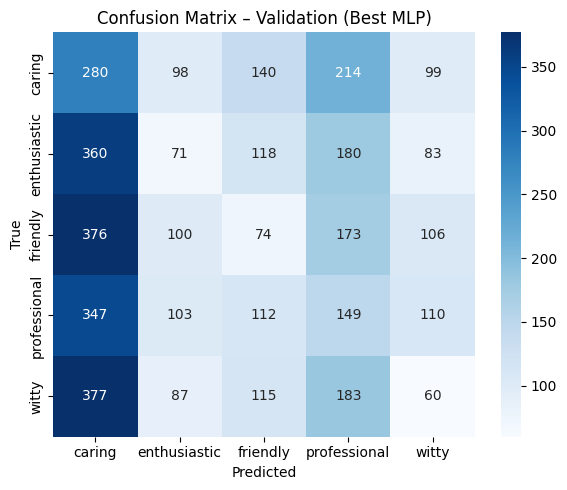


Training final model on TRAIN+VALIDATION with best hyperparameters...

Evaluating final model on TEST set...

=== Test Accuracy ===
0.1402

=== Test Classification Report ===
              precision    recall  f1-score   support

      caring       0.11      0.04      0.06       830
enthusiastic       0.11      0.04      0.06       812
    friendly       0.16      0.38      0.23       830
professional       0.13      0.18      0.15       822
       witty       0.12      0.06      0.08       821

    accuracy                           0.14      4115
   macro avg       0.13      0.14      0.12      4115
weighted avg       0.13      0.14      0.12      4115

=== Test Confusion Matrix ===
[[ 36  67 414 238  75]
 [ 67  36 399 218  92]
 [ 67  70 314 281  98]
 [ 91  77 423 144  87]
 [ 68  65 411 230  47]]


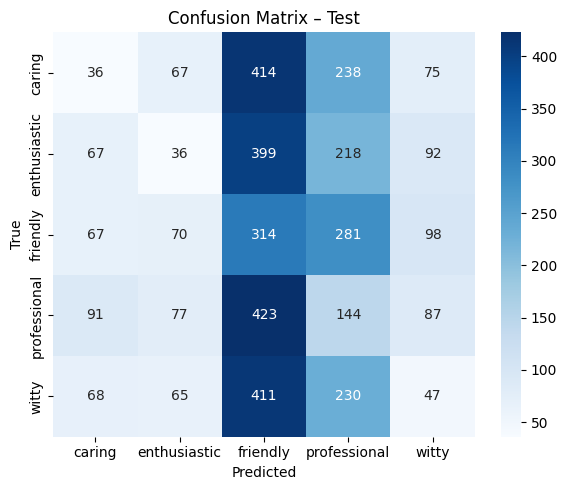

In [16]:
if __name__ == "__main__":
    main()